### Importing the libraries and data

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
# Fetch the Dataset
raw_df = pd.read_csv('listings.csv')
raw_df.head(3)

C:\Users\kondavee\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190710134553,2019-07-11,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.15
1,15400,https://www.airbnb.com/rooms/15400,20190710134553,2019-07-11,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.73
2,17402,https://www.airbnb.com/rooms/17402,20190710134553,2019-07-11,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,14,14,0,0,0.41


### Analyse the features and drop the features which are not needed.

In [3]:
# Dropping initial columns
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'space', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(drop_cols, axis=1)

In [4]:
# Checking the NA values across all the features
df.isna().sum()

id                                                  0
summary                                          3876
experiences_offered                                 0
host_since                                         47
host_response_time                              24782
host_response_rate                              24782
host_acceptance_rate                            83850
host_is_superhost                                  47
host_listings_count                                47
host_total_listings_count                          47
host_has_profile_pic                               47
host_identity_verified                             47
street                                              0
neighbourhood                                       1
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    83850
city                                              133
state                                           16843
zipcode                     

In [5]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) 

Note: host_listings_count and host_total_listings_count are the same so will drop one of them, Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [6]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

Note: There are multiple columns for property location, hence dropping 'zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'

In [7]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

Note: Multiple columns of minimum and maximum night stays exist, hence we will let minimum_nights and maximum_nights exist and drop the other features

In [8]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

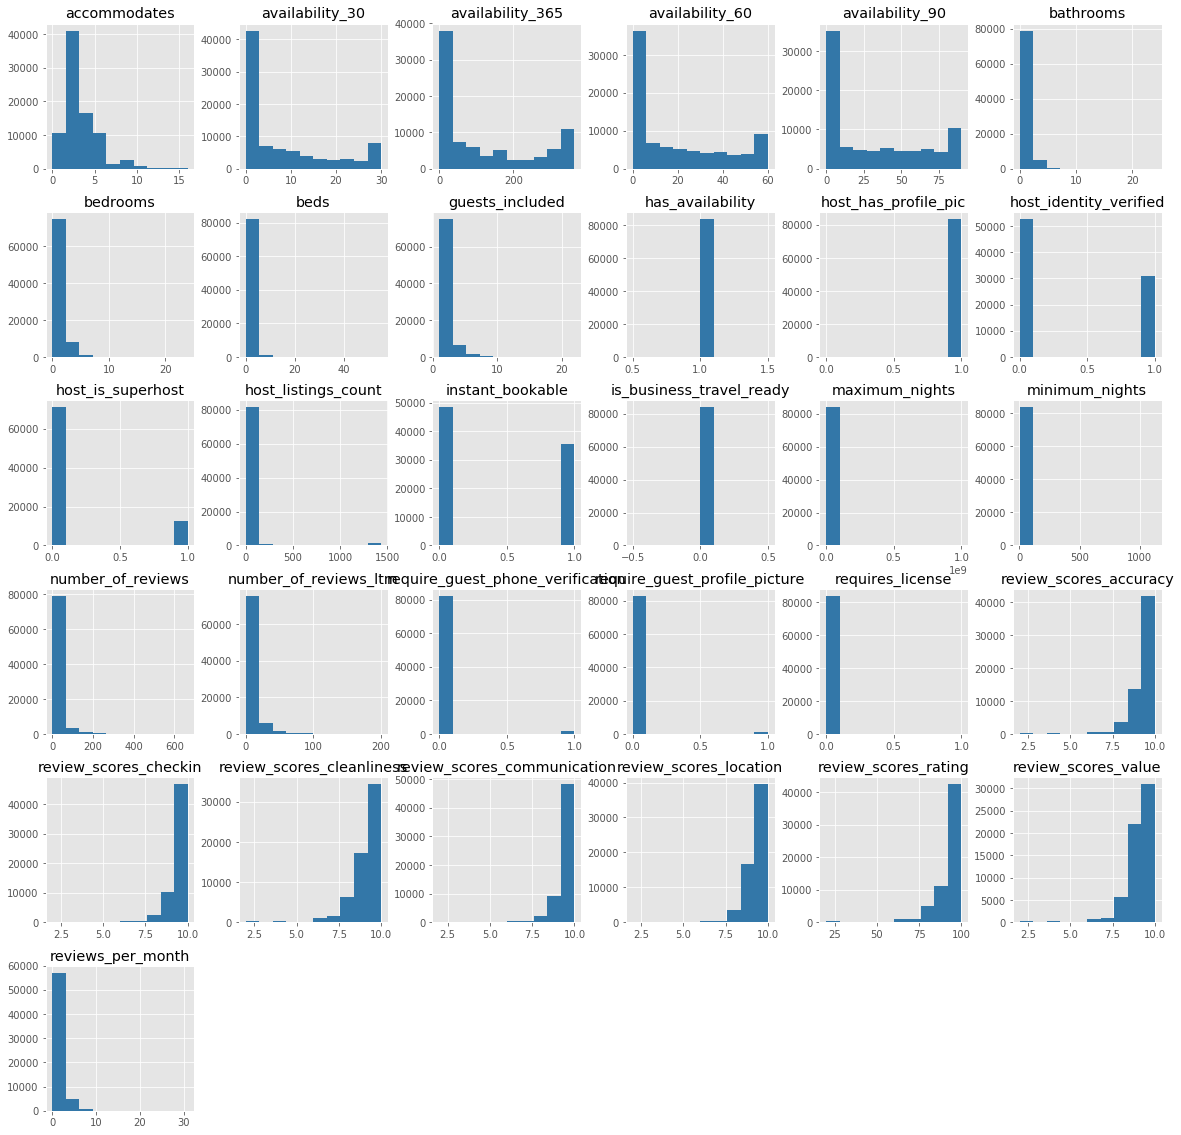

In [9]:
# Encoding fetures with false/true with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)
plt.style.use(u'ggplot')

# Plotting the distribution of numerical and boolean features
a = df.hist(figsize=(20,20), color='#3377a8')

Note: In the above plots we can identify that several columns only contain one category and hence they can be dropped:

In [10]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

In [11]:
# experiences_offered
df.experiences_offered.value_counts()

none        82060
business      606
family        508
social        452
romantic      224
Name: experiences_offered, dtype: int64

Note: Since most experiences offered are none, will drop this feature.

In [12]:
df.drop('experiences_offered', axis=1, inplace=True)

In [13]:
# host_since

# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

In [14]:
# host_response_time

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.432821
unknown               0.295552
within a few hours    0.148372
within a day          0.101729
a few days or more    0.021527
Name: host_response_time, dtype: float64

In [15]:
# host_response_rate

df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

In [16]:
df.dropna(subset=['host_since'], inplace=True)

In [17]:
# property_type

# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'


In [18]:
# Fill NA values for 'bathrooms', 'bedrooms', 'beds' features.
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [19]:
# bed_type

df.bed_type.value_counts()

Real Bed         83068
Pull-out Sofa      428
Futon              188
Couch               72
Airbed              47
Name: bed_type, dtype: int64

Note: Since Most properties have the same bed type so this feature can be dropped

In [20]:
df.drop('bed_type', axis=1, inplace=True)

In [21]:
# amenities

df.amenities[:1].values

array(['{TV,"Cable TV",Wifi,Kitchen,"Paid parking off premises","Smoking allowed","Free street parking","Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Outlet covers",Bathtub,"Children’s books and toys","Babysitter recommendations",Crib,"Pack ’n Play/travel crib","Room-darkening shades","Children’s dinnerware","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection","Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Patio or balcony","Luggage dropoff allowed","Long term stays allowed","No stairs or steps to enter","Wide entrance","Extra space around bed","Accessible-height bed","No stairs or steps to enter","Wide doorway to guest bathroom","Bathtub with bath chair","Accessible-height toilet","Host greets you","Handheld shower head","Roll-in shower"}'],
     

In [22]:
# Possible amenities list
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
print (list(amenities_set))

['', 'Roll-in shower', 'Dining table', 'Game console', 'Dog(s)', 'Day bed', 'Memory foam mattress', 'En suite bathroom', 'Ceiling fan', 'Dishes and silverware', 'Lockbox', 'Heated towel rack', 'Mini fridge', 'Laptop friendly workspace', 'First aid kit', 'Apple TV', 'Bedroom comforts', 'Private hot tub', 'Printer', 'Baby bath', 'Rain shower', 'Safe', 'Microwave', 'Fire extinguisher', 'Mobile hoist', 'Alfresco bathtub', 'Babysitter recommendations', 'Pets live on this property', 'Shared hot tub', 'Espresso machine', 'Gas oven', 'Beach essentials', 'Private pool', 'Lake access', 'Office', 'Shampoo', 'Single level home', 'High chair', 'Sound system', 'Luggage dropoff allowed', 'Wide entrance', 'Wide entrance for guests', 'Window guards', 'Children’s books and toys', 'Fireplace guards', 'Doorman', 'Free street parking', 'Terrace', 'Convection oven', 'Garage parking', 'No stairs or steps to enter', 'Warming drawer', 'BBQ grill', 'Self check-in', 'Patio or balcony', 'Refrigerator', 'Waterfron

In [23]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

C:\Users\kondavee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [24]:
# Replacing Null values with 0 for new features
replace_null_cols = df.iloc[:,41:].columns
df[replace_null_cols] = df[replace_null_cols].fillna(0)

# Produces a list of amenity features where one category contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'gym', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


Note: Converting Feature "Price" to Int

In [25]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

Note: Converting Feature "security_deposit" to Int

In [26]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

Note: Converting Feature "cleaning_fee" to Int

In [27]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

Note: Converting Feature "extra_people" to Int

In [28]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [29]:
# calendar_updated
df.calendar_updated.value_counts()[:5]

today           21536
a week ago       4884
2 weeks ago      4823
yesterday        3788
2 months ago     3612
Name: calendar_updated, dtype: int64

Note: Since Most properties have the same calendar_updated type so this feature can be dropped

In [30]:
df.drop('calendar_updated', axis=1, inplace=True)

In [31]:
# availability - There are multiple different measures of availability
df.drop(['availability_30', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [32]:
# time_since_first_review
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

today = datetime.today()

df['time_since_first_review'] = (datetime(today.year, today.month, today.day) - df.first_review).astype('timedelta64[D]')

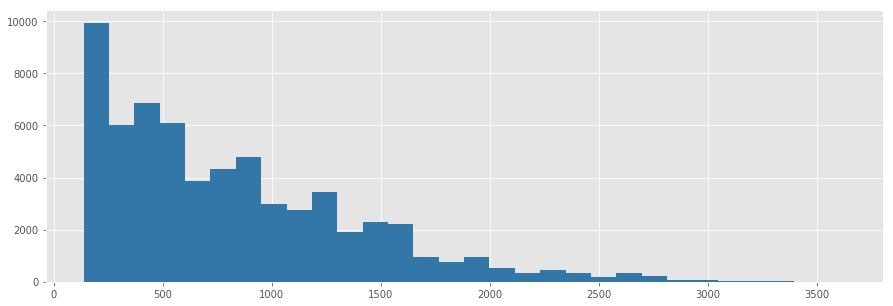

In [33]:
plt.style.use(u'ggplot')
df.time_since_first_review.hist(figsize=(15,5), bins=30,color='#3377a8');

In [34]:
df['time_since_first_review'] = pd.cut(df['time_since_first_review'], bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)], labels=['0-6 months','6-12 months', '1-2 years','2-3 years','4+ years'], include_lowest=True)
df['time_since_first_review'] = df['time_since_first_review'].astype('str')
df['time_since_first_review'].fillna('no reviews', inplace=True)

In [35]:
# time_since_last_review
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime
today = datetime.today()

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(today.year, today.month, today.day) - df.last_review).astype('timedelta64[D]')

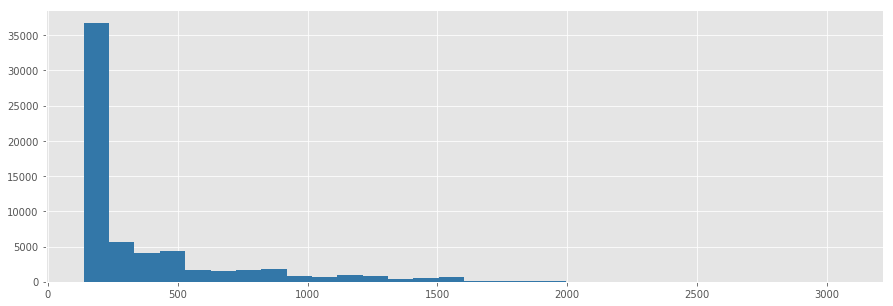

In [36]:
# Distribution of the number of days since last review
plt.style.use(u'ggplot')
df.time_since_last_review.hist(figsize=(15,5), bins=30, color='#3377a8');

In [37]:
df['time_since_last_review'] = pd.cut(df['time_since_last_review'], bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)], labels=['0-2 weeks','2-8 weeks','2-6 months','6-12 months','1+ year'], include_lowest=True)
df['time_since_last_review'] = df['time_since_last_review'].astype('str')
df['time_since_last_review'].fillna('no reviews', inplace=True)

In [38]:
df.drop('last_review', axis=1, inplace=True)

In [39]:
# review ratings columns

variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
variables_to_plot.pop(0)


for col in variables_to_plot:
    df[col] = pd.cut(df[col], bins=[0, 8, 9, 10], labels=['0-8/10', '9/10', '10/10'], include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna('no reviews', inplace=True)


In [40]:
df['review_scores_rating'] = pd.cut(df['review_scores_rating'], bins=[0, 80, 95, 100], labels=['0-79/100', '80-94/100', '95-100/100'], include_lowest=True)
df['review_scores_rating'] = df['review_scores_rating'].astype('str')
df['review_scores_rating'].fillna('no reviews', inplace=True)

In [41]:
# cancellation_policy

df.cancellation_policy.value_counts()

strict_14_with_grace_period    35858
flexible                       27105
moderate                       19951
super_strict_60                  469
super_strict_30                  391
luxury_moderate                   17
strict                             9
luxury_super_strict_95             3
Name: cancellation_policy, dtype: int64

In [42]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict',
    'super_strict_60': 'strict',
    'strict': 'strict',
    'luxury_super_strict_95': 'strict',
    'luxury_moderate': 'moderate',
    'strict_14_with_grace_period': 'strict'
    }, inplace=True)

In [43]:
df.cancellation_policy.value_counts()

strict      36730
flexible    27105
moderate    19968
Name: cancellation_policy, dtype: int64

In [44]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

#### Converting Summary Categorical features to the sentiment scores respectively.

In [45]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(score)))
    return score.get("compound")

In [46]:
df['summary'] = df['summary'].astype(str).apply(sentiment_analyzer_scores)

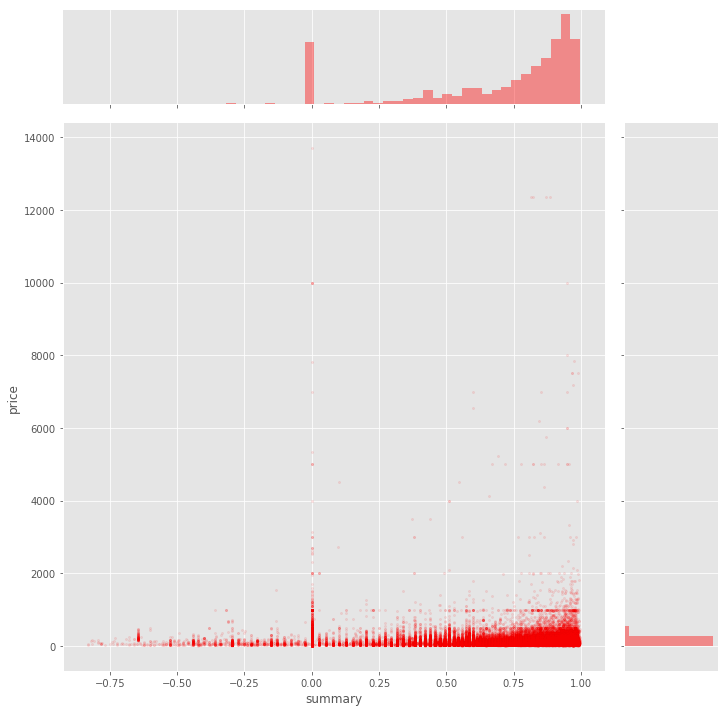

In [47]:
ax = sns.jointplot(x=df['summary'],y=df['price'],
              joint_kws={'alpha':0.1,'s':5,'color':'red'},
              marginal_kws={'color':'red'}, height = 10)


## Exploratory Data Analysis (EDA):

C:\Users\kondavee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


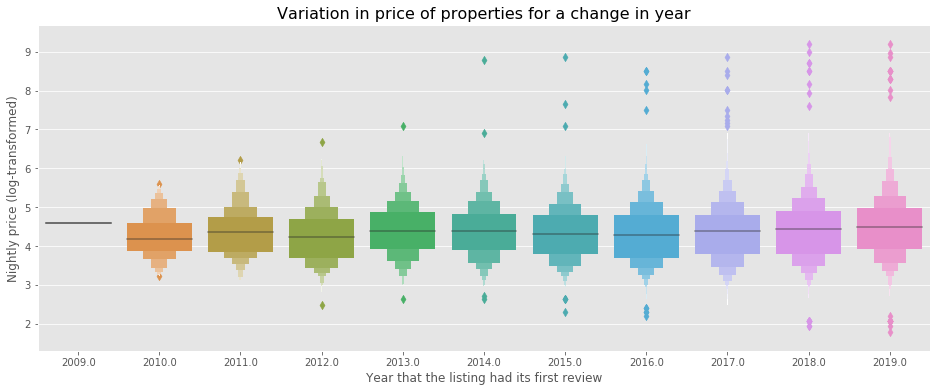

In [48]:
plt.figure(figsize=(16,6))
sns.boxenplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Variation in price of properties for a change in year', fontsize=16)
plt.style.use(u'ggplot')
plt.show()

In [49]:
# Dropping host_since and first_review as they are not needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

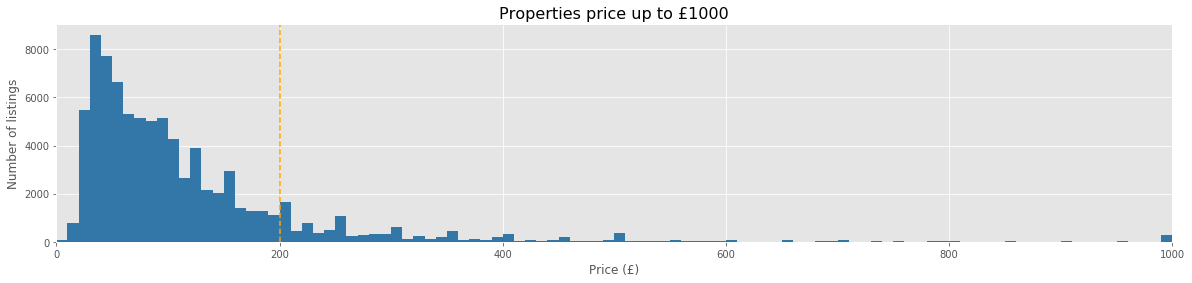

In [50]:
# Distribution of prices upto £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000), grid=True, color='#3377a8')
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Properties price up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.style.use(u'ggplot')
plt.show()

In [51]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

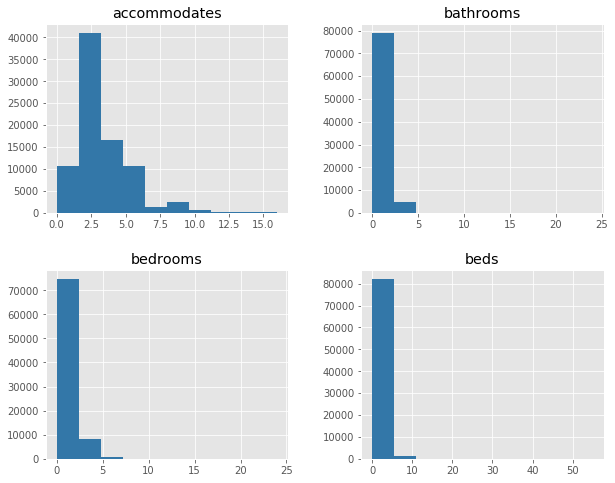

In [52]:
plt.style.use(u'ggplot')

df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(10,8), color='#3377a8');

In [53]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    

    plt.style.use(u'ggplot')

    #plt.grid(b=True, which='major', color='#d0e3f1', linestyle='-')

    plt.subplots_adjust(top=0.80)
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['#c9464d', '#46c9c2'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    #ax1.set_facecolor("lightslategray")
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['#c9464d', '#46c9c2'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    #ax2.set_facecolor("lightslategray")
    
    plt.show()

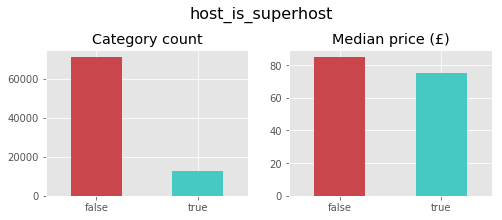

In [54]:
binary_count_and_price_plot('host_is_superhost')

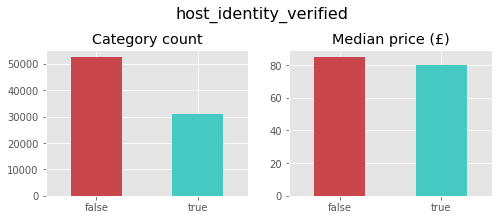

In [55]:
binary_count_and_price_plot('host_identity_verified')

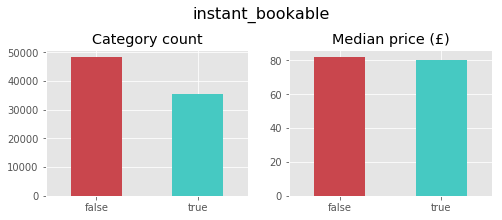

In [56]:
binary_count_and_price_plot('instant_bookable')

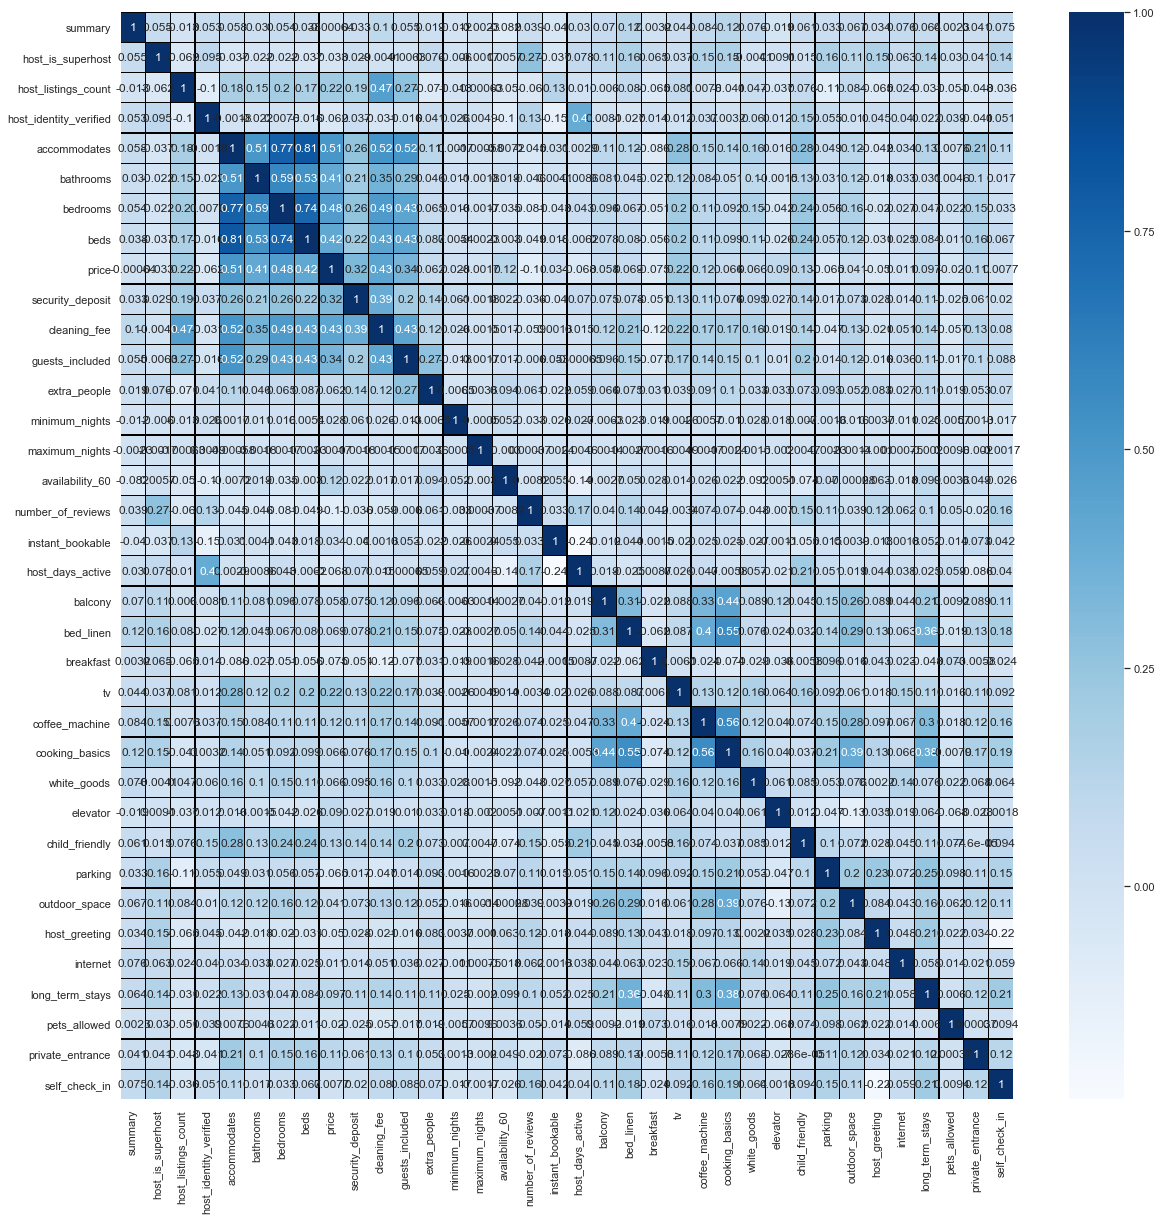

In [57]:
# Correlation Matrix
sns.set(font_scale=1)
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),linewidths=0.1,annot=True,linecolor='black',cmap='Blues')
plt.xticks(rotation=90)
plt.show()

In [58]:
transformed_df = pd.get_dummies(df)

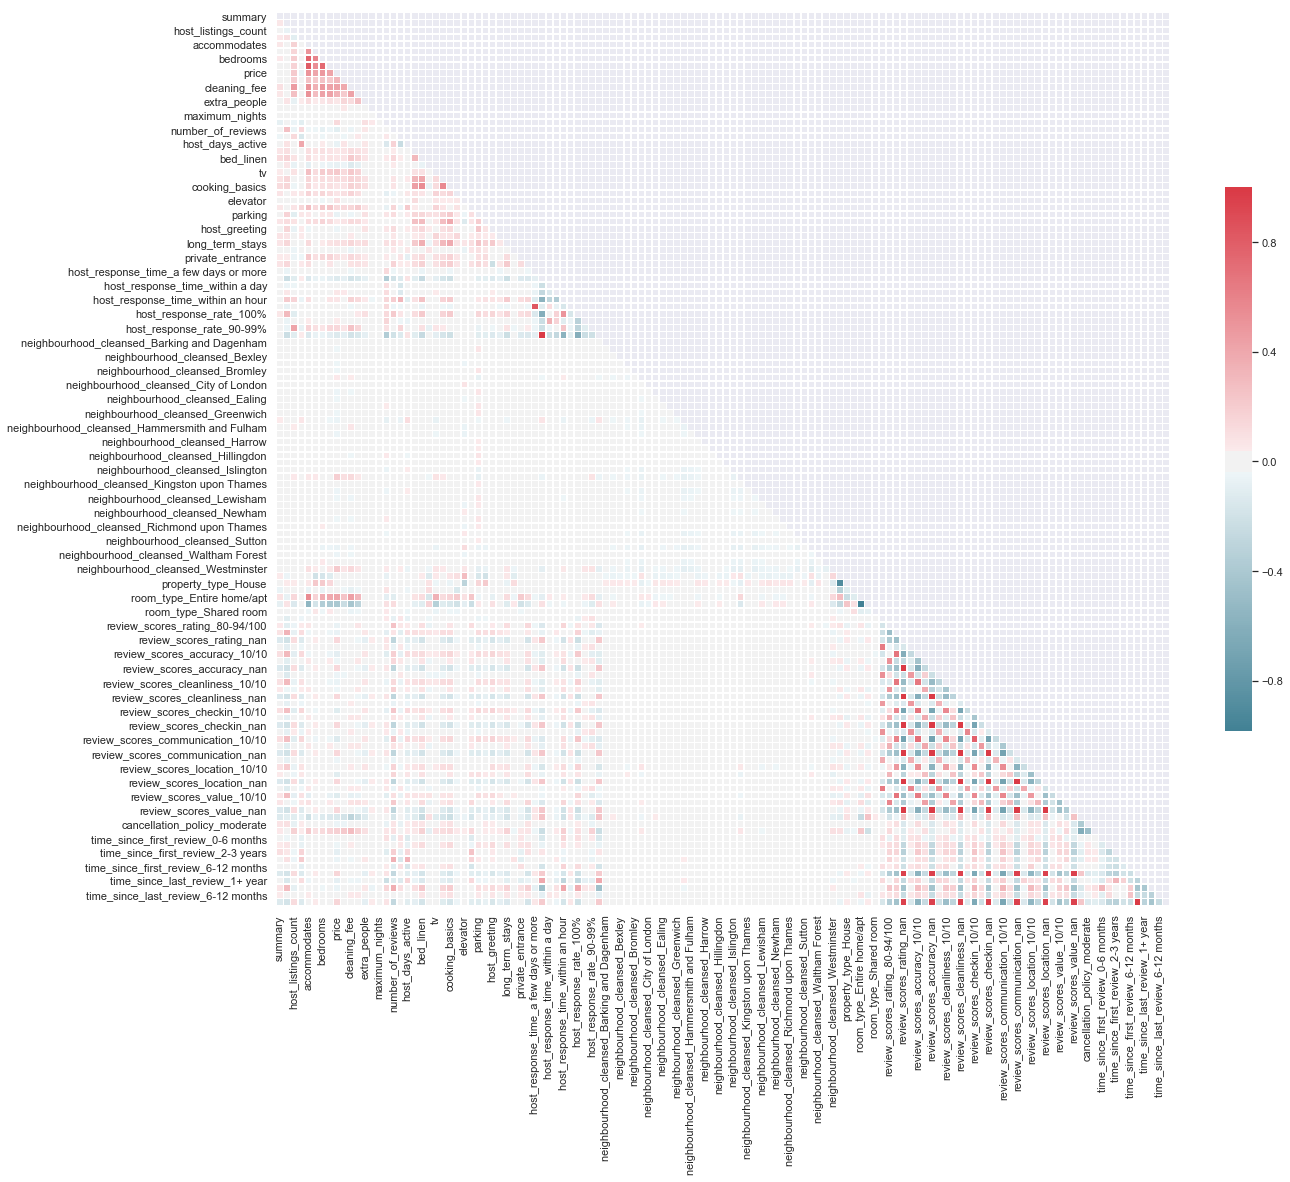

In [59]:
# Create a covariance matrix
corr = transformed_df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [60]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

### Distribution of the data and transform

In [61]:
numerical_columns = ['accommodates', 'availability_60', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

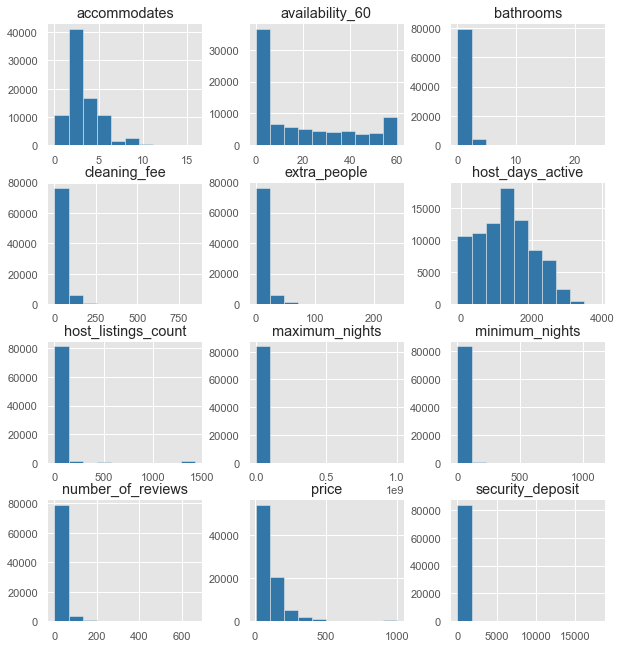

In [62]:
plt.style.use(u'ggplot')
transformed_df[numerical_columns].hist(figsize=(10,11), color='#3377a8');

#### Transforming above features by Standardizing.

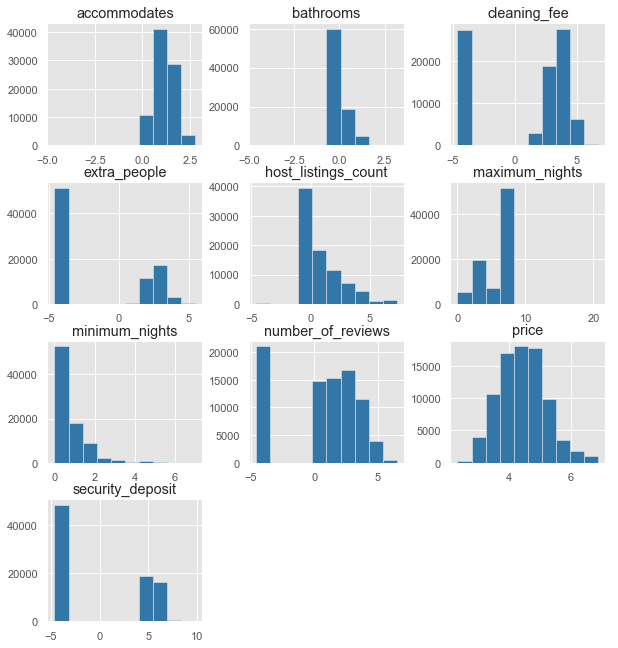

In [63]:
# Log transforming columns

# Removing items not to be transformed
numerical_columns = [i for i in numerical_columns if i not in ['availability_60', 'host_days_active']]

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])
    
    
plt.style.use(u'ggplot')
transformed_df[numerical_columns].hist(figsize=(10,11), color='#3377a8');


## Model Train and Test

In [64]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

C:\Users\kondavee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\kondavee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Split data to Test and Train

In [65]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Linear Regression

In [66]:
# Linear Regression

multiple_linear_regressor = LinearRegression()
multiple_linear_regressor.fit(X_train, y_train)

# y_pred contains all the values predicted by trained model
mul_y_pred = multiple_linear_regressor.predict(X_test)
mul_y_train_pred = multiple_linear_regressor.predict(X_train)

print("Training MSE:", round(mean_squared_error(y_train, mul_y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, mul_y_pred),4))
print("\n")
print("Training r2:", round(r2_score(y_train, mul_y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, mul_y_pred),4))

Training MSE: 0.1918
Validation MSE: 0.1928


Training r2: 0.6846
Validation r2: 0.6786


### Random Forest

In [67]:
# Random Forest.

# create regressor object 
regressor = RandomForestRegressor(n_estimators = 150, random_state = 0)
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)
rf_y_train_pred = regressor.predict(X_train)
rf_y_test_pred = regressor.predict(X_test)

print("Training MSE:", round(mean_squared_error(y_train, rf_y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, rf_y_test_pred),4))
print("\n")
print("Training r2:", round(r2_score(y_train, rf_y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, rf_y_test_pred),4))


Training MSE: 0.0192
Validation MSE: 0.1422


Training r2: 0.9684
Validation r2: 0.7629


###  Neural Network

In [68]:
# Building the model
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

# Compiling the model
model.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               14080     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 113,153
Trainable params: 113,153
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
# Training the model
model_history = model.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

Instructions for updating:
Use tf.cast instead.
Train on 60337 samples, validate on 6705 samples
Epoch 1/15
60337/60337 [==============================] - 3s 57us/step - loss: 0.6146 - mean_squared_error: 0.6146 - val_loss: 0.2213 - val_mean_squared_error: 0.2213
Epoch 2/15
60337/60337 [==============================] - 2s 37us/step - loss: 0.1909 - mean_squared_error: 0.1909 - val_loss: 0.1909 - val_mean_squared_error: 0.1909
Epoch 3/15
60337/60337 [==============================] - 2s 35us/step - loss: 0.1692 - mean_squared_error: 0.1692 - val_loss: 0.1787 - val_mean_squared_error: 0.1787
Epoch 4/15
60337/60337 [==============================] - 2s 35us/step - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.1764 - val_mean_squared_error: 0.1764
Epoch 5/15
60337/60337 [==============================] - 2s 34us/step - loss: 0.1479 - mean_squared_error: 0.1479 - val_loss: 0.1804 - val_mean_squared_error: 0.1804
Epoch 6/15
60337/60337 [==============================] - 2s 34us/st

In [70]:
# MSE and r squared values
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\n")
print("Training r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.1057
Validation MSE: 0.1727


Training r2: 0.8262
Validation r2: 0.7121


## Conclusion:

 We now have modelled the data over various algorithms and clearly see that Random Forest Classifier provides the best result with a mean squared error of 0.1422 and r2 of 0.7629.